In [ ]:
# Imports libraries for data processing, modeling, evaluation, and visualization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [ ]:
# Sets image size, batch size and epochs
image_size = (100, 100)
batch_size = 32
epochs = 200

# Defines directories for training, validation, and test datasets
train_dir = "/kaggle/input/alzheimers-dataset-early-stage-vs-health/Processed Dataset/training"
val_dir = "/kaggle/input/alzheimers-dataset-early-stage-vs-health/Processed Dataset/validation"
test_dir = "/kaggle/input/alzheimers-dataset-early-stage-vs-health/Processed Dataset/test"

# Defines class names for the classification task
class_names = ['Healthy', 'Sick']

In [ ]:
# Defines a CNN model architecture for image classification
def build_model(input_shape, num_classes):
    model = keras.Sequential([
        Rescaling(1./255, input_shape=input_shape),

        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.3),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.4),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
# Plots training and validation accuracy and loss curves
def plot_training_history(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

In [ ]:
# Plots a normalized confusion matrix as a heatmap
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)

    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(6,6))
    sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (%)")

    plt.show()

In [ ]:
# Loads training, validation, and test datasets from directories with appropriate splits and settings
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle=False,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 9792 files belonging to 2 classes.
Using 7834 files for training.


I0000 00:00:1746882352.704601      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 4347 files belonging to 2 classes.
Using 869 files for validation.
Found 1088 files belonging to 2 classes.


In [ ]:
# Enables prefetching for efficient data loading during training and evaluation
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

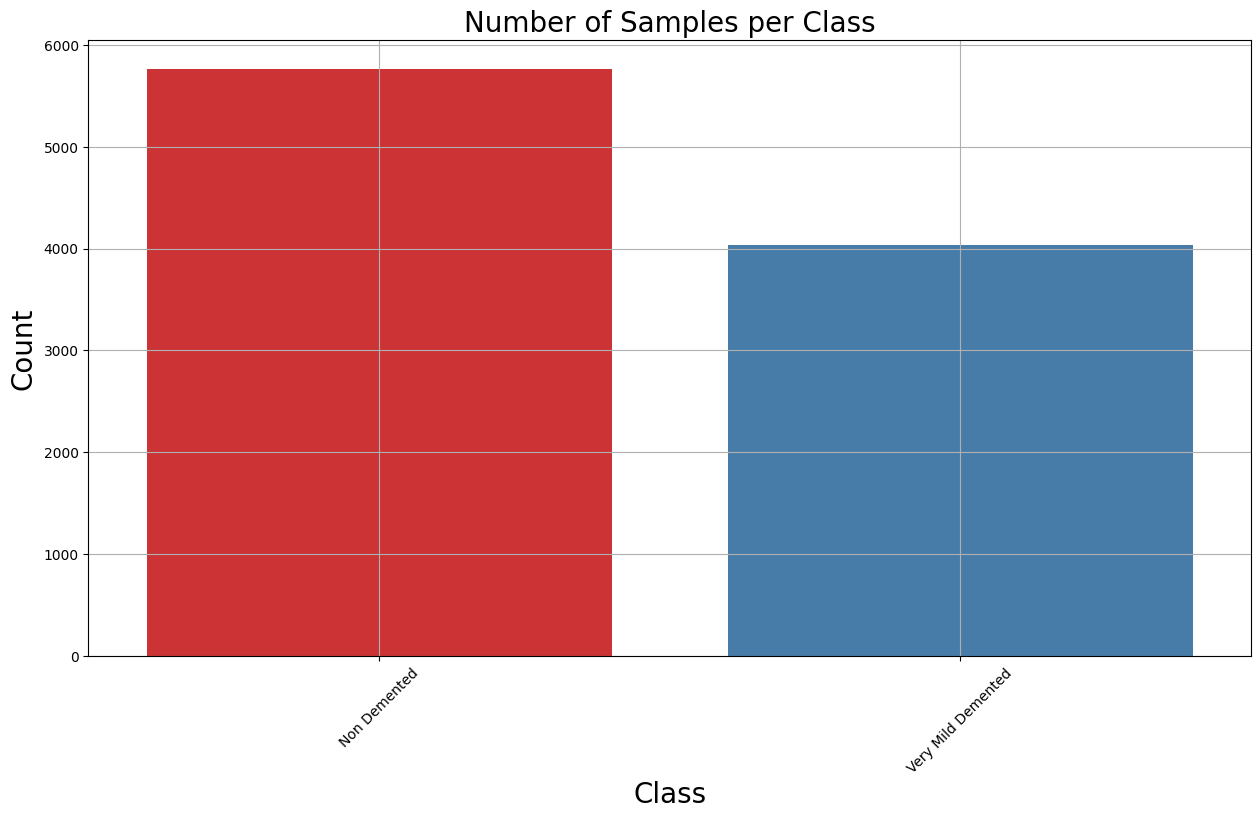

In [ ]:
# Plots the number of samples per class in the training set
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}

df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])

plt.figure(figsize=(15,8))
sns.barplot(x=df["Class"], y=df["Count"], palette="Set1")
plt.xlabel("Class", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("Number of Samples per Class", fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

In [ ]:
# Builds and compiles the CNN model for training
model = build_model(input_shape=(100, 100, 3), num_classes=2)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Displays a summary of the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 98, 98, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 47, 47, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,732,930 (6.61 MB)

 Trainable params: 1,732,482 (6.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Sets up early stopping and learning rate reduction callbacks for training
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

In [ ]:
# Trains the model with early stopping and learning rate scheduling, validating after each epoch
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200


I0000 00:00:1746882364.880732      80 service.cc:148] XLA service 0x7a9a500042f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746882364.881415      80 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746882365.531170      80 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/245 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.5642 - loss: 9.1078 

I0000 00:00:1746882370.720133      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


245/245 ━━━━━━━━━━━━━━━━━━━━ 74s 260ms/step - accuracy: 0.5793 - loss: 1.7512 - val_accuracy: 0.3993 - val_loss: 35.8953 - learning_rate: 0.0010
Epoch 2/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 54s 219ms/step - accuracy: 0.5940 - loss: 0.6794 - val_accuracy: 0.3982 - val_loss: 23.8096 - learning_rate: 0.0010
Epoch 3/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 61s 249ms/step - accuracy: 0.5905 - loss: 0.6772 - val_accuracy: 0.5420 - val_loss: 1.0276 - learning_rate: 0.0010
Epoch 4/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 59s 240ms/step - accuracy: 0.5916 - loss: 0.6764 - val_accuracy: 0.5834 - val_loss: 0.7111 - learning_rate: 0.0010
Epoch 5/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 60s 243ms/step - accuracy: 0.5937 - loss: 0.6756 - val_accuracy: 0.5857 - val_loss: 0.7025 - learning_rate: 0.0010
Epoch 6/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 54s 220ms/step - accuracy: 0.5884 - loss: 0.6775 - val_accuracy: 0.5857 - val_loss: 0.7021 - learning_rate: 0.0010
Epoch 7/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 53s 217ms/step - accuracy: 0.5896

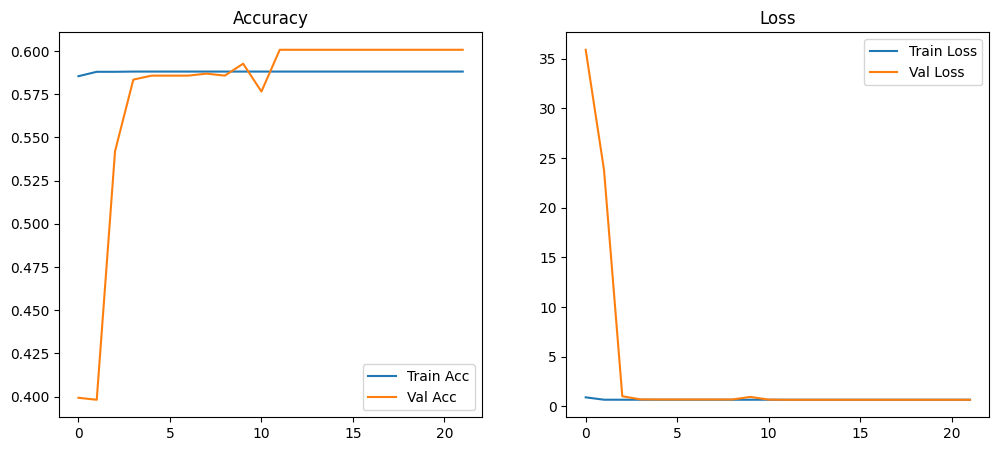

In [ ]:
# Plots training and validation metrics after model training
plot_training_history(history)

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step
              precision    recall  f1-score   support

     Healthy     0.6007    1.0000    0.7505       522
        Sick     0.0000    0.0000    0.0000       347

    accuracy                         0.6007       869
   macro avg     0.3003    0.5000    0.3753       869
weighted avg     0.3608    0.6007    0.4508       869



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


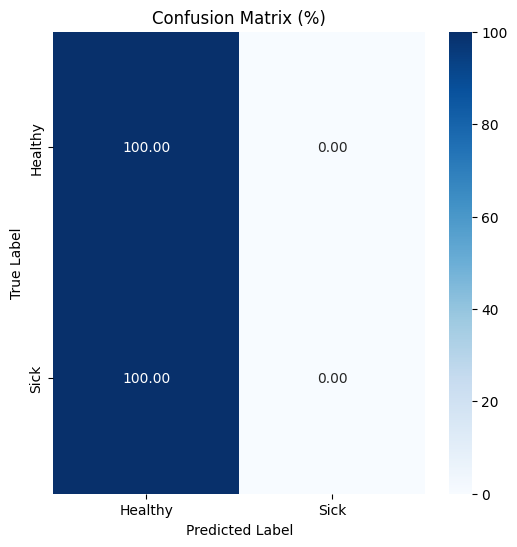

In [ ]:
# Evaluates model performance on the validation set and displays metrics and confusion matrix
val_labels = np.concatenate([y.numpy() for x, y in val_ds])
val_preds = model.predict(val_ds)
val_pred_classes = np.argmax(val_preds, axis=1)
val_true_classes = np.argmax(val_labels, axis=1)

print(classification_report(val_true_classes, val_pred_classes, digits=4, target_names=class_names))

plot_confusion_matrix(val_true_classes, val_pred_classes, class_names)

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step

Test Classification Report:
              precision    recall  f1-score   support

     Healthy     0.5882    1.0000    0.7407       640
        Sick     0.0000    0.0000    0.0000       448

    accuracy                         0.5882      1088
   macro avg     0.2941    0.5000    0.3704      1088
weighted avg     0.3460    0.5882    0.4357      1088



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


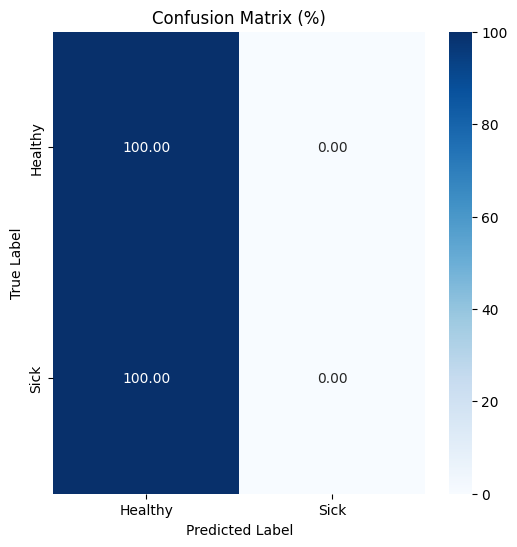

In [ ]:
# Evaluates model performance on the test set and displays metrics and confusion matrix
test_labels = np.concatenate([y.numpy() for x, y in test_ds])
test_preds = model.predict(test_ds)
test_pred_classes = np.argmax(test_preds, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

print("\nTest Classification Report:")
print(classification_report(test_true_classes, test_pred_classes, digits=4, target_names=class_names))

plot_confusion_matrix(test_true_classes, test_pred_classes, class_names)